In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Read CSV 
data = pd.read_csv("data_smartphone.csv")

# Display the first few rows
data.head()

,Brand,Model,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
0,Apple,iPhone 13 Pro,128 GB,6 GB,6.1,12 + 12 + 12,3095,999
1,Samsung,Galaxy S21 Ultra,256 GB,12 GB,6.8,108 + 10 + 10 + 12,5000,1199
2,OnePlus,9 Pro,128 GB,8 GB,6.7,48 + 50 + 8 + 2,4500,899
3,Xiaomi,Redmi Note 10 Pro,128 GB,6 GB,6.67,64 + 8 + 5 + 2,5020,279
4,Google,Pixel 6,128 GB,8 GB,6.4,50 + 12.2,4614,799


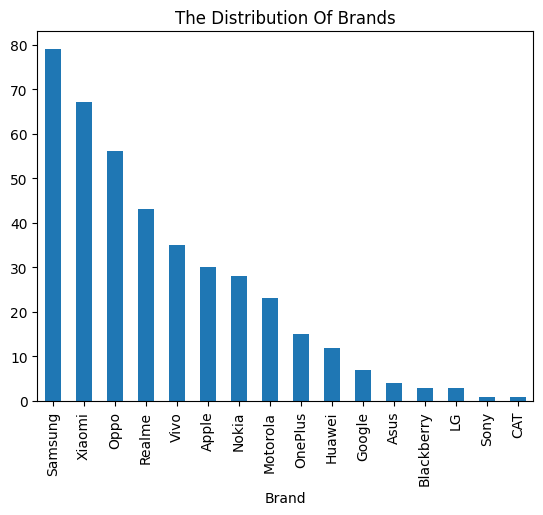

In [3]:
data['Brand'].value_counts().plot.bar()
plt.title("The Distribution Of Brands")
plt.show()

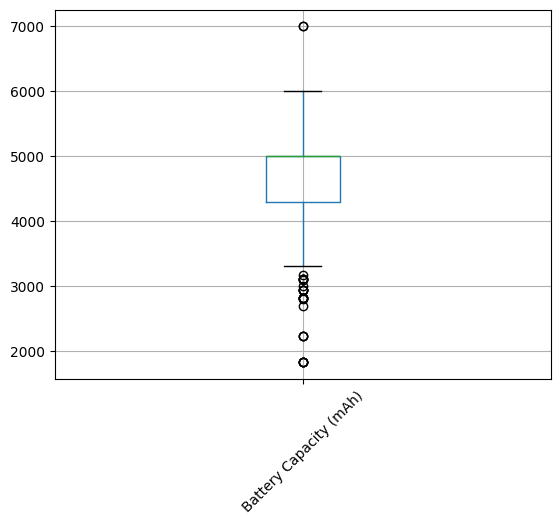

In [4]:
data.boxplot()
plt.xticks(rotation =45)
plt.show()

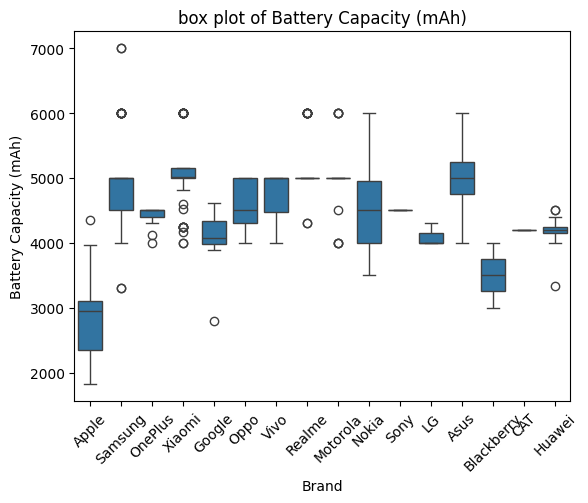

In [5]:
numeric_cols= data.select_dtypes(include=['number']).columns

for i in numeric_cols :
    sns.boxplot(data =data , x= 'Brand' , y= i)
    plt.ylabel(i)
    plt.xticks(rotation=45)
    plt.title("box plot of "+i)
    plt.show()

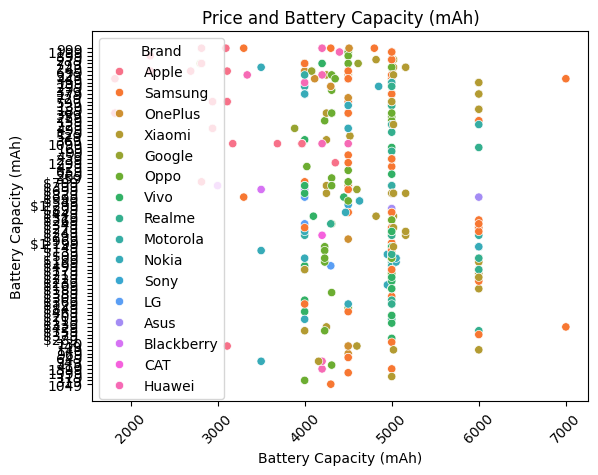

In [6]:
numeric_cols = data.select_dtypes(include=['number']).columns.difference(["Price ($)"])

for i in numeric_cols:
    sns.scatterplot(data=data, x=i, y='Price ($)', hue='Brand')
    plt.ylabel(i)
    plt.xticks(rotation=45)
    plt.title(f"Price and {i}")
    plt.show()

<Axes: >

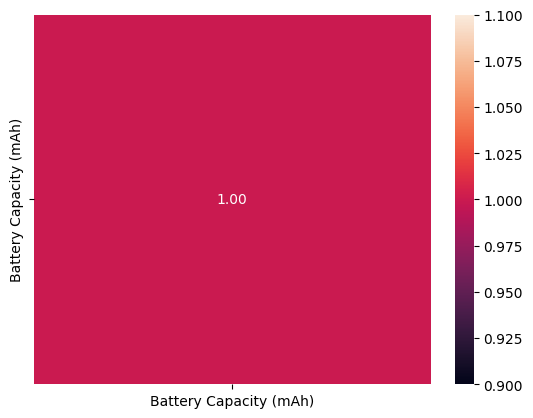

In [7]:
numeric_cols= data.select_dtypes(include=['number'])
corr_mat=numeric_cols.corr()
sns.heatmap(corr_mat,annot=True, fmt='.2f')

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Bersihkan kolom harga
data['Price ($)'] = (
    data['Price ($)']
    .replace(r'[\$,]', '', regex=True)  # note the r before the string
    .astype(float)
)

# Pisahkan fitur dan target
x = data.drop(columns=['Price ($)'])
y = data['Price ($)']

# Ambil hanya kolom numerik
x_numeric = x.select_dtypes(include=['number'])

# Normalisasi hanya fitur numerik
scaler = MinMaxScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x_numeric), columns=x_numeric.columns)

# Split data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)

# Latih model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(x_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(x_test)

In [9]:
# Evaluasi performa model
mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_xgb)

print("=== Evaluasi Model XGBoost ===")
print(f"MSE  : {mse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")                          # R² Score

=== Evaluasi Model XGBoost ===
MSE  : 51985.1975
MAE  : 125.5011
RMSE : 228.0026
R²   : 0.4058


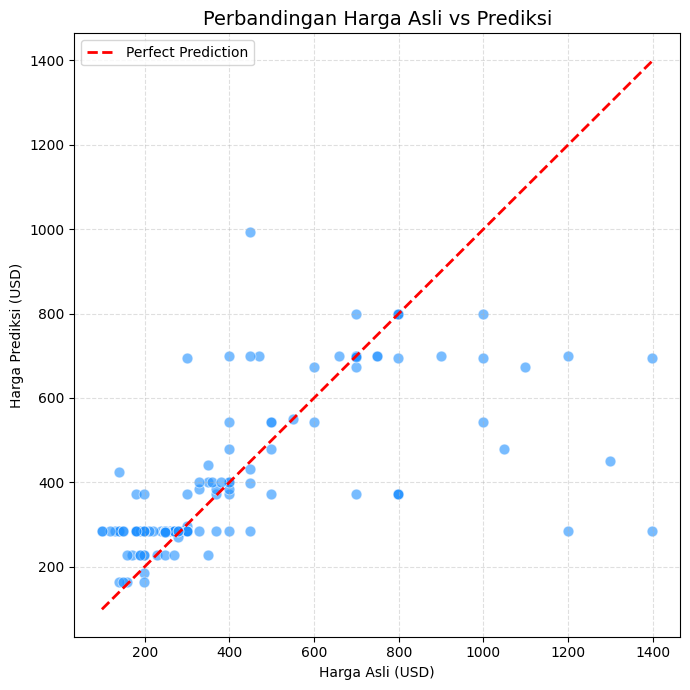

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat figure
plt.figure(figsize=(7,7))

# Scatter plot: harga asli vs prediksi
sns.scatterplot(x=y_test, y=y_pred_xgb, color="dodgerblue", alpha=0.6, s=60)

# Garis diagonal (garis sempurna prediksi = real)
max_val = max(y_test.max(), y_pred_xgb.max())
min_val = min(y_test.min(), y_pred_xgb.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

# Label dan judul
plt.title("Perbandingan Harga Asli vs Prediksi", fontsize=14)
plt.xlabel("Harga Asli (USD)")
plt.ylabel("Harga Prediksi (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [11]:
# Ambil semua kolom brand hp di x.columns 
brand_list = [col for col in x.columns if col.startswith('Brand_')]

def predict_phone_price(brand, storage, ram, camera, screen_size, battery) :
    new_data = pd.DataFrame([{
        'Storage ': storage,
        'RAM ': ram,
        'Screen Size (inches)': screen_size,
        'Camera (MP)': camera,
        'Battery Capacity (mAh)': battery,
    }])
    
    for b in brand_list:
        if b == f'Brand_{brand}':
            new_data[b] = 1
        else:
            new_data[b] = 0
            
    new_data = new_data[x_numeric.columns]
    
    new_data_scaled = pd.DataFrame(scaler.transform(new_data), columns=x_numeric.columns)
    
    predicted_price = xgb_model.predict(new_data_scaled)[0]
    
    print(f"📱 Prediksi harga untuk smartphone {brand} (Storage: {storage} GB, RAM: {ram} GB, Camera: {camera} MP dan Screen: {screen_size} inch): ${predicted_price:.2f}")
    return predicted_price

In [12]:
predict_phone_price(
    brand="Apple",
    storage=256,
    ram=8,
    camera=108,
    screen_size=6.8,
    battery=5000
)

📱 Prediksi harga untuk smartphone Apple (Storage: 256 GB, RAM: 8 GB, Camera: 108 MP dan Screen: 6.8 inch): $284.30


np.float32(284.29892)